![This is an image](Quant-Trading.jpg)

<font size="3">
Please visit our website <a href="https://www.quant-trading.co" target="_blank">quant-trading.co</a> for more tools on quantitative finance and data science.
</font>

# **MONTECARLO SIMULATION - JUMP DIFFUSION PROCESS**

## **¿How can you build a montercarlo simulation for Jump Difussion Process?**

<font size="3"> Montecarlo simulation is a powerful technique that allows you visualize different paths a financial asset could take in the future. You can also use this technique for derivatives pricing. In this notebook we are showing how you can run a montecarlo simulation for a jump diffusion process in python. Remember that a jump difussion process is the combination of a geometric brownian motion plus a jump process. This is one of the most widely used stochastic processes in finance to model the behavior of stocks and other financial assets. If you would like to know more about the mathematics of this jump difussion process please look  <a href="https://quant-trading.co/category/tools/" target="_blank">here</a>. You might also want to look how to implement a montecarlo simulation for Geometric Brownian Motion. If that is the case please look <a href="https://quant-trading.co/montercarlo-simulation-geometric-brownian-motion/" target="_blank">here</a>.<br><br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from numpy.random import rand
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import datetime
import yfinance as yf 

## **How can we generate the jumps?**

<font size="3"> The first  thing that we need to do is simulate the jumps. We can do that simulating a Poisson process with the number of jumps per period. Here theta is the average number of jumps and M is the number of simulation that we would like to run. The explanation of what is shown in the next scrip can be found <a href="https://quant-trading.co/montercarlo-simulation-geometric-brownian-motion/" target="_blank">here</a><br><br>

In [2]:
def Poisson(M,theta):
#M: number of simulations
#theta: average number of jumps

    N = np.zeros(M)

    for i in range(0,M):
        p = np.exp(-theta)                     #probability of N = 0 
        F = p                               
        N[i] = 0
        U = rand()
        while U > F:    
            N[i] = N[i]+1
            p = p*theta/N[i]
            F= F+p

    return N

## **Average number of jumps**

<font size="3"> Next you can see the different number of jumps per period for 15 simulations<br><br>

In [3]:
print(Poisson(15,0.01))
print(Poisson(15,0.1))
print(Poisson(15,1))
print(Poisson(15,10))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 3. 1. 0.]
[12.  6.  5. 13.  7.  5. 10. 16. 12.  6. 10.  7.  6.  9. 12.]


## **Case 1: Jumps are log-normally distributed**

<font size="3"> The first case we are going to show is the case where the jumps are lognormally distributed. In that case we assume Yi are lognormally distributed with parameters (a,b), where a is the average jump size and b is the standard deviation of those jumps <br><br>
    
<font size="3"> So, we need to define some parameters such as: a) The number of simulations that we are going to run, b) The number of steps to use in each path the asset will follow, c) The spot price of our financial asset, d) The time step in the simulation, e) The risk-free interest rate, f) The volatility of our financial asset, g) The average jump size, h) The standard deviation of the jumps <br><br>

In [4]:
lamda = 0.1                 #Average number of jumps for the period T
T = 1                       #Time to maturity - We are using one year
d = 250                     #Number of steps - We are using daily steps. In one year there are apox 250 working days
delta_t = T/d               #time step for the simulation. 
M = 10**2                   #Number of paths - We are using 1000 paths for illustrative purposes - The more paths, the more accurate.
a = 0.25                    #Average jump size
b = 0.05                    #Jump standard deviation
m = np.exp(a+0.5*b**2)-1    #m = average jump - 1. Yi are lognormal distributed. Thus, the average is exp(a+0.5b^2)

r = 0.05                    #Interest rate
sigma = 0.12               #Volatility
S0 = 100                   #Spot price of our asset

## **Generate uniformly distributed random variables**

<font size="3"> We can use the ramdom.randn function to generate normally distributed random variables as following <br><br>

In [5]:
#Random variables generation
z1 = np.random.randn(M,d)                   #Normal random variable to create Geometric Brownian Motion
z2 = np.random.randn(M,d)                   #Normal random variable to create Jumps

## **Generate Poisson distributed random variables and get the jumps**

<font size="3"> We need to get the jumps for each path<br><br>

In [6]:
N = Poisson(M,lamda*delta_t)                #Poisson random variable
for i in range(0,d-1):
    N = np.append(N,Poisson(M,lamda*delta_t))

N = np.resize(N,(M,d))
N

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## **Generate Jump sizes**

<font size="3"> We need to get the jump sizes in each path<br><br>

In [7]:
J = a*N+b*np.sqrt(N)*z2               #Sum of the jumps logarithms. This has a lognormal distribution
J

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## **Generate the simulation paths**

<font size="3"> Using the discretized equation of the geometric brownian motion, the matrix of normal random variables and the jump sizes vector we can create the paths for our simulation as follows<br><br>

In [8]:
x = np.zeros((M,d+1))
x[:,0]=np.log(S0)

#Path generation
for j in range(0,d):
    x[:,j+1]= x[:,j] + (r-lamda*m-0.5*sigma**2)*delta_t+sigma*np.sqrt(delta_t)*z1[:,j]+J[:,j]

path = np.exp(x)
path

array([[100.        , 100.41470862, 100.18688247, ..., 115.93332548,
        116.00527814, 115.55350872],
       [100.        ,  99.99228844,  98.83945193, ..., 115.66995831,
        115.65867395, 116.11062636],
       [100.        ,  98.85341211, 100.13013891, ...,  86.04390378,
         85.87365552,  85.43718422],
       ...,
       [100.        , 100.02573642,  99.56561613, ..., 113.80644035,
        113.27974067, 112.75291176],
       [100.        ,  99.68146218, 100.38583655, ..., 130.94940444,
        129.45587105, 130.74359409],
       [100.        , 100.40411658, 100.7548146 , ..., 104.60339086,
        104.42674894, 104.90931303]])

## **Plot the results**

<font size="3"> We can plot the results as follows<br><br>

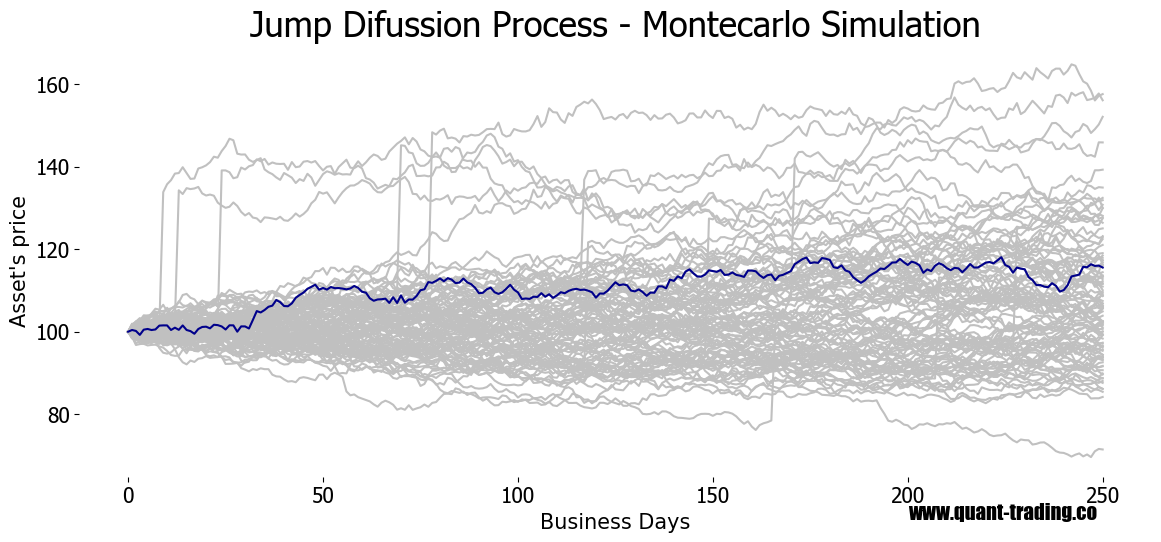

In [9]:
#Plot the paths        

fig = plt.figure()

ax = fig.add_subplot(1,1,1)

ax.plot(path[0:100,:].transpose(),c='silver')
ax.plot(path[0:1,:].transpose(),c='darkblue')
ax.set_facecolor('white') 

plt.yticks(fontname = "Tahoma",fontsize=15)
plt.xticks(fontname = "Tahoma",fontsize=15)
plt.ylabel("Asset's price",fontsize=15)
plt.xlabel("Business Days",fontsize=15)

plt.title("Jump Difussion Process - Montecarlo Simulation", size=25, family='Tahoma')
plt.box(on=None)


plt.subplots_adjust(bottom=0.1, right=1.8, top=1.0)
plt.text(200, np.min(path[0:100,:])-15,'www.quant-trading.co' , color='black', fontsize=15,family='Impact')
plt.show()

## **Case 2: Jumps are exponentially distributed**

<font size="3"> Jumps can have another distribution other than lognormal. In this second case, the jump distribution is exponential. Remember that Yi can be interpred as the return after the jump <br><br>

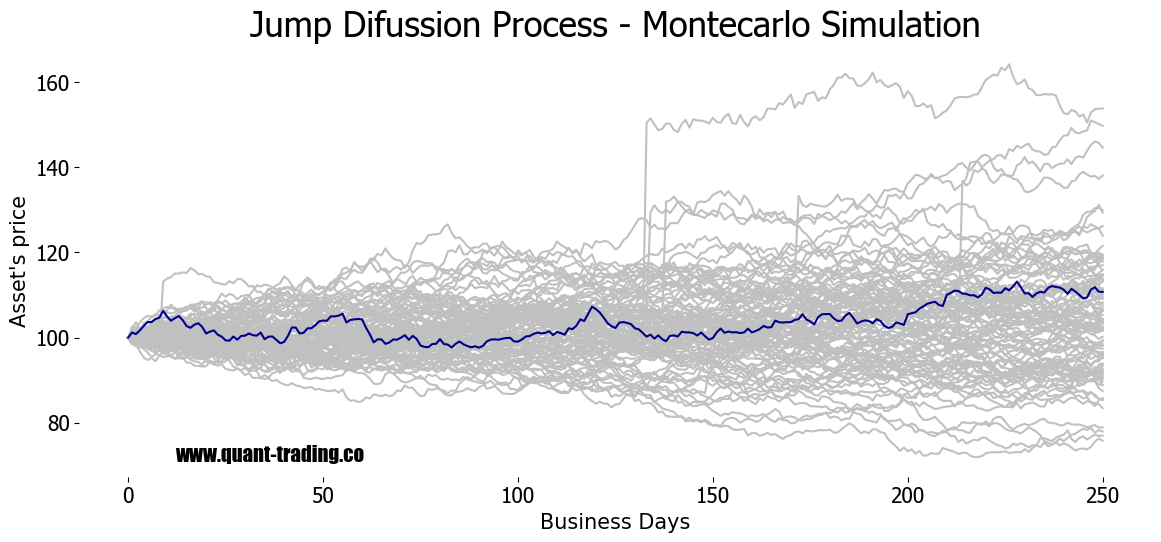

In [10]:
lamda = 0.1                         
T = 1                               
d = 250                              
delta_t = T/d                       
M = 10**2                           
a = 5                               
m = 1/a                          #Average Jump Size  


r = 0.05                    
sigma = 0.12                 
S0 = 100

#Random variables generation
z1 = np.random.randn(M,d)                             

N = Poisson(M,lamda*delta_t)            
for i in range(0,d-1):
    N = np.append(N,Poisson(M,lamda*delta_t))

N = np.resize(N,(M,d))
J = np.zeros((M,d))

#Loop to generate J (sum of the Jumps)
for i in range(0,M):
    for j in range(0,d):
        if N[i,j] == 0:
            J[i,j] =0
        else:
            accumulation = 0
            for k in range(0,int(N[i,j])):                
                accumulation = accumulation + (-np.log(rand())/a)                
            J[i,j] = accumulation

x = np.zeros((M,d+1))

#Path generation
for j in range(0,d):
    x[:,j+1]= x[:,j] + (r-lamda*m-0.5*sigma**2)*delta_t+sigma*np.sqrt(delta_t)*z1[:,j]+J[:,j]

path = S0*np.exp(x)


##########################-------------------Plot the paths  -------------------------------------------########################
 
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

ax.plot(path[0:100,:].transpose(),c='silver')
ax.plot(path[0:1,:].transpose(),c='darkblue')
ax.set_facecolor('white') 

plt.yticks(fontname = "Tahoma",fontsize=15)
plt.xticks(fontname = "Tahoma",fontsize=15)
plt.ylabel("Asset's price",fontsize=15)
plt.xlabel("Business Days",fontsize=15)

plt.title("Jump Difussion Process - Montecarlo Simulation", size=25, family='Tahoma')
plt.box(on=None)


plt.subplots_adjust(bottom=0.1, right=1.8, top=1.0)
plt.text(12, np.min(path[0:100,:])-1,'www.quant-trading.co' , color='black', fontsize=15,family='Impact')
plt.show()

## **Case 3: Jumps are uniformly distributed**

<font size="3"> Jumps can have another distribution other than lognormal or exponential. In this third case, the jump distribution is uniform. Remember that Yi can be interpred as the return after the jump <br><br>

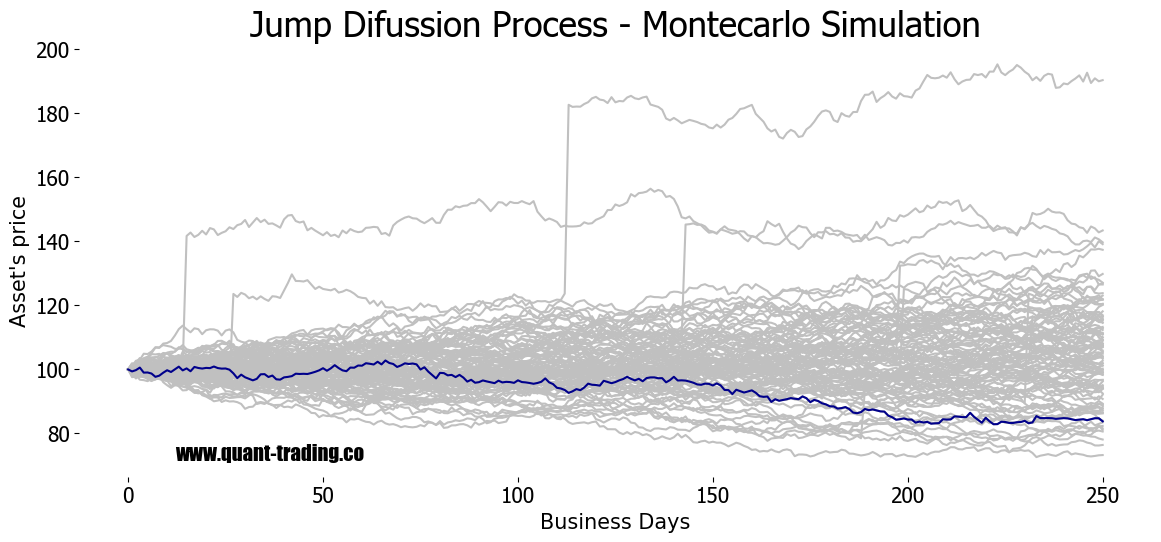

In [11]:
lamda = 0.1                         
T = 1                               
d = 250                              
delta_t = T/d                       
M = 10**2                           
a = 1                               #Lower bound of the interval
b = 1.5                             #Upper bound of the interval
m = 0.5*(a+b)-1                     #m = average jump - 1. Yi are uniformly distributed. Thus, the average is 0.5*(a+b)


r = 0.05                    
sigma = 0.12                 
S0 = 100                    

#Random variables generation
z1 = np.random.randn(M,d)                             

N = Poisson(M,lamda*delta_t)            
for i in range(0,d-1):
    N = np.append(N,Poisson(M,lamda*delta_t))

N = np.resize(N,(M,d))
J = np.zeros((M,d))

#Loop to generate J (sum of the Jumps)
for i in range(0,M):
    for j in range(0,d):
        if N[i,j] == 0:
            J[i,j] =0
        else:
            accumulation =0
            for k in range(0,int(N[i,j])):                
                accumulation = accumulation + np.log((a+rand()*(b-a)))               #generando variable aleatoria uniforme [a,b]
            J[i,j] = accumulation

x = np.zeros((M,d+1))

#Path generation
for j in range(0,d):
    x[:,j+1]= x[:,j] + (r-lamda*m-0.5*sigma**2)*delta_t+sigma*np.sqrt(delta_t)*z1[:,j]+J[:,j]

path = S0*np.exp(x)


##########################-------------------Plot the paths  -------------------------------------------########################   

fig = plt.figure()

ax = fig.add_subplot(1,1,1)

ax.plot(path[0:100,:].transpose(),c='silver')
ax.plot(path[0:1,:].transpose(),c='darkblue')
ax.set_facecolor('white') 

plt.yticks(fontname = "Tahoma",fontsize=15)
plt.xticks(fontname = "Tahoma",fontsize=15)
plt.ylabel("Asset's price",fontsize=15)
plt.xlabel("Business Days",fontsize=15)

plt.title("Jump Difussion Process - Montecarlo Simulation", size=25, family='Tahoma')
plt.box(on=None)


plt.subplots_adjust(bottom=0.1, right=1.8, top=1.0)
plt.text(12, np.min(path[0:100,:])-1,'www.quant-trading.co' , color='black', fontsize=15,family='Impact')
plt.show()

## **Example with QQQ ETF**

<font size="3"> An interesting application of the Montecarlo Simulation of financial asset prices is to show the different possibilities they can take in the future. Here we will show an example using QQQ, which is the ETF that replicates the Nasdaq index. The first thing we need to do is to download the historic information using the <a href="https://quant-trading.co/how-to-download-data-from-yahoo-finance-api/" target="_blank">yahoo finance API</a><br><br>

In [12]:
end = datetime.datetime(2024,8,13)
start = datetime.datetime(2010,12,31)

prices = yf.Ticker('QQQ')
prices_hist = prices.history(period="max")
prices_hist.reset_index(inplace=True)
prices_hist['Date'] = pd.to_datetime(prices_hist['Date'], utc=True).dt.date  
prices_hist['Date'] = pd.to_datetime(prices_hist['Date'])
prices_hist = prices_hist.loc[(prices_hist['Date'] >=start)&(prices_hist['Date'] <= end)]
prices_hist

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
2973,2010-12-31,48.270569,48.297095,47.934557,48.155617,38540100,0.0,0.0,0.0
2974,2011-01-03,48.606589,49.243239,48.588904,48.907230,90994300,0.0,0.0,0.0
2975,2011-01-04,49.084061,49.119431,48.562360,48.871845,43851500,0.0,0.0,0.0
2976,2011-01-05,48.721530,49.305127,48.695004,49.287445,43787400,0.0,0.0,0.0
2977,2011-01-06,49.340498,49.481976,49.234390,49.446606,46139600,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6394,2024-08-07,446.489990,449.000000,434.369995,434.769989,54929200,0.0,0.0,0.0
6395,2024-08-08,441.059998,448.989990,437.149994,448.070007,47890100,0.0,0.0,0.0
6396,2024-08-09,446.739990,452.059998,445.609985,450.410004,33574000,0.0,0.0,0.0
6397,2024-08-12,451.390015,454.369995,448.549988,451.380005,27795000,0.0,0.0,0.0


## **Run the Montecarlo Simulation for the Jump Difussion Process**

<font size="3"> We update some parameters like the spot price or the volatility<br><br>

In [13]:
lamda = 0.1                         
T = 1                               
d = 250                              
delta_t = T/d                       
M = 10**2                           
a = -5                               
m = 1/a                          #Average Jump Size  


r = 0.05                    
sigma = 0.25                 
S0 = 462.57


z1 = np.random.randn(M,d)                             

N = Poisson(M,lamda*delta_t)            
for i in range(0,d-1):
    N = np.append(N,Poisson(M,lamda*delta_t))

N = np.resize(N,(M,d))
J = np.zeros((M,d))


for i in range(0,M):
    for j in range(0,d):
        if N[i,j] == 0:
            J[i,j] =0
        else:
            accumulation = 0
            for k in range(0,int(N[i,j])):                
                accumulation = accumulation + (-np.log(rand())/a)                
            J[i,j] = accumulation

x = np.zeros((M,d+1))


for j in range(0,d):
    x[:,j+1]= x[:,j] + (r-lamda*m-0.5*sigma**2)*delta_t+sigma*np.sqrt(delta_t)*z1[:,j]+J[:,j]

path = S0*np.exp(x)

## **Create a Dataframe for the paths**

<font size="3"> We create a dataframe for the paths including a date in the future as follows<br><br>

In [14]:
initial_date = datetime.datetime(2024, 8, 13)
df1 = pd.DataFrame(data=path.transpose())
df1['Date'] = initial_date
date = initial_date

for i in range(0,df1.shape[0]):
    df1['Date'].iloc[i] = date
    date += datetime.timedelta(days=1)
    
df1

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Date
0,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,...,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,462.570000,2024-08-13
1,460.366071,469.164381,454.262276,459.012628,463.532266,464.294943,466.434015,455.361035,454.451371,454.224657,...,459.868629,455.320628,460.322402,468.416401,460.984034,463.391451,450.360362,461.701390,474.181782,2024-08-14
2,480.472665,480.283847,451.149979,445.936625,464.688415,466.459173,457.534687,453.045166,446.764615,444.851145,...,453.308027,452.548817,456.047382,476.406116,454.292719,474.725536,449.082795,460.450063,489.149195,2024-08-15
3,470.651183,494.719623,454.377701,441.774189,470.286355,461.434906,470.611956,452.843958,442.355570,457.647705,...,439.413075,453.308346,460.254664,478.437021,459.723524,469.425833,447.531451,457.031597,493.506477,2024-08-16
4,472.188653,486.897177,458.061443,439.988148,466.187205,471.447385,474.204291,457.259161,438.541308,462.140921,...,442.937615,446.276943,465.254097,487.574541,463.780981,459.397600,447.632619,454.639720,501.574373,2024-08-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,435.423975,449.553647,562.258662,475.845405,484.149288,417.092323,304.223246,661.827224,634.108132,324.136288,...,593.706351,391.699831,569.388411,522.570625,481.886661,485.865251,463.266477,415.011256,433.138278,2025-04-16
247,439.660358,457.665060,570.179871,482.463826,478.171012,413.005270,305.884594,664.554065,639.511731,316.799164,...,581.641092,383.365438,583.024808,521.444597,481.955013,489.861426,455.804182,421.794884,429.878785,2025-04-17
248,434.679015,466.369969,574.805154,486.838393,477.539600,412.551987,305.459006,665.617534,645.621649,317.975454,...,596.273854,382.463981,570.400456,516.466560,492.960783,493.065468,446.430238,423.448964,422.718856,2025-04-18
249,431.609677,467.274808,569.428509,484.129388,491.458586,406.962776,309.239395,647.019006,630.769534,324.676916,...,595.103708,389.838633,582.516299,525.411959,493.178525,498.901648,451.847643,428.291200,420.288435,2025-04-19


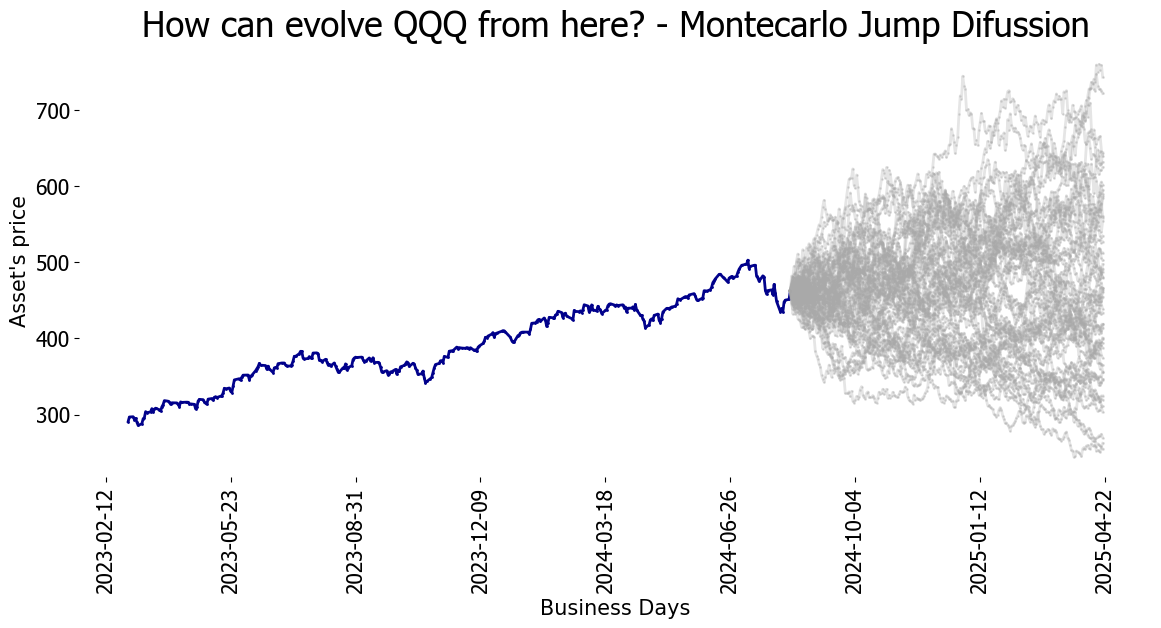

In [15]:
#------------------------Plot historic prices of QQQ and simulation of future possible paths----------------------------------#
font = font_manager.FontProperties(family='Arial',weight='bold', style='normal', size=15)
tick_spacing1 = 100


fig = plt.figure()

ax1 = fig.add_subplot(1,1,1)
ax1.plot(prices_hist['Date'].tail(365),prices_hist['Close'].tail(365),marker='o', linestyle='solid',linewidth=2,color='darkblue',alpha=0.99,label='USDCOP',markersize=1)
for i in range(0,50):
    ax1.plot(df1['Date'],df1[i],marker='o', linestyle='solid',linewidth=2,color='darkgrey',alpha=0.3,label='QQQ',markersize=1)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing1))
plt.xticks(rotation=90)
plt.yticks(fontname = "Tahoma",fontsize=15)
plt.xticks(fontname = "Tahoma",fontsize=15)
ax1.title.set_fontfamily('arial')
ax1.axis([None, None, None, None])
ax1.set_facecolor('white')
vals = ax1.get_yticks()
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.box(on=None)
 

plt.yticks(fontname = "Tahoma",fontsize=15)
plt.xticks(fontname = "Tahoma",fontsize=15)
plt.ylabel("Asset's price",fontsize=15)
plt.xlabel("Business Days",fontsize=15)

plt.title("How can evolve QQQ from here? - Montecarlo Jump Difussion", size=25, family='Tahoma')

plt.subplots_adjust(bottom=0.1, right=1.8, top=1.0)
plt.show()

<font size="3"> If this content is helpful and you want to make a donation please click on the button <br>

[![paypal](https://www.paypalobjects.com/en_US/i/btn/btn_donateCC_LG.gif)](https://www.paypal.com/cgi-bin/webscr?cmd=_s-xclick&hosted_button_id=29CVY97MEQ9BY)